In [1]:
import os, sys
sys.path.append('../common/nifti_mrs_from_raw')
sys.path.append('../')
import importlib

import numpy as np
from scipy.io import loadmat
from matplotlib import pyplot as plt
from pathlib import Path
import re
import fsl_mrs.utils.mrs_io as mrs_io
import fsl_mrs.core.nifti_mrs as ntools
from fsl_mrs.utils.preproc import nifti_mrs_proc as proc
import numpy as np

from datetime import datetime


from fsl_mrs.utils import preproc
from fsl_mrs.core import NIFTI_MRS
from fsl_mrs.core import nifti_mrs as ntools
from fsl_mrs.utils.misc import shift_FID

from nifti_mrs_from_raw_pv3 import main as bruker2niimrs
import nifti_mrs_from_raw_pv3 as bruker2fsl

from bids_structure import *
from custom_functions import *

In [2]:
# from https://git.fmrib.ox.ac.uk/fsl/fsl_mrs/-/blob/master/fsl_mrs/utils/preproc/nifti_mrs_proc.py

def remove_unlike(data, ppmlim=None, sdlimit=1.96, niter=2, figure=False, report=None, return_indices=False):
    '''Remove unlike dynamics operating on DIM_DYN

    :param NIFTI_MRS data: Data to truncate or pad
    :param figure: True to show figure.
    :param report: Provide output location as path to generate report

    :return: Data passing likeness criteria.
    :return: Data failing likness criteria
    '''
    if data.shape[:3] != (1, 1, 1):
        raise OnlySVS("remove_unlike only specified for SVS data")

    if data.ndim > 5:
        raise ValueError('remove_unlike only makes sense for a single dynamic dimension. Combined coils etc. first')
    elif data.ndim < 5:
        raise ValueError('remove_unlike only makes sense for data with a dynamic dimension')

    goodFIDs, badFIDs, gIndicies, bIndicies, metric = \
        preproc.identifyUnlikeFIDs(data[0, 0, 0, :, :].T,
                                   data.bandwidth,
                                   data.spectrometer_frequency[0],
                                   nucleus=data.nucleus[0],
                                   ppmlim=ppmlim,
                                   sdlimit=sdlimit,
                                   iterations=niter,
                                   shift=True)

    if figure or report:
        from fsl_mrs.utils.preproc.unlike import identifyUnlikeFIDs_report
        fig = identifyUnlikeFIDs_report(goodFIDs,
                                        badFIDs,
                                        gIndicies,
                                        bIndicies,
                                        metric,
                                        data.bandwidth,
                                        data.spectrometer_frequency[0],
                                        nucleus=data.nucleus[0],
                                        ppmlim=ppmlim,
                                        sdlimit=sdlimit,
                                        html=report)
        if figure:
            fig.show()
    
    if return_indices:
        return gIndicies, bIndicies

    # goodFIDs = np.asarray(goodFIDs).T
    # goodFIDs = goodFIDs.reshape([1, 1, 1] + list(goodFIDs.shape))

    if len(badFIDs) > 0:
        bad_out, good_out  = ntools.split(
            data,
            data.dim_tags[0],
            gIndicies)
    else:
        good_out = data.copy()

    good_out.add_hdr_field(
        f'{data.dim_tags[0]} Indices',
        gIndicies,
        doc=f"Data's original index values in the {data.dim_tags[0]} dimension")

    if len(badFIDs) > 0:
        bad_out.add_hdr_field(
            f'{data.dim_tags[0]} Indices',
            bIndicies,
            doc=f"Data's original index values in the {data.dim_tags[0]} dimension")
    else:
        bad_out = None

    # Update processing prov
    processing_info = f'{__name__}.remove_unlike, '
    if ppmlim is None:
        processing_info += 'ppmlim=None, '
    else:
        processing_info += f'ppmlim={ppmlim}, '
    processing_info += f'sdlimit={sdlimit}, '
    processing_info += f'niter={niter}.'

    update_processing_prov(good_out, 'Outlier removal', processing_info)

    return good_out, bad_out


In [3]:
from fsl_mrs import __version__


def update_processing_prov(nmrs_obj: NIFTI_MRS, method, details):
    """Insert appropriate processing provenance information into the
    NIfTI-MRS header extension.

    :param nmrs_obj: NIFTI-MRS object which has been modified
    :type nmrs_obj: fsl_mrs.core.NIFTI_MRS
    :param method: [description]
    :type method: str
    :param details: [description]
    :type details: str
    """
    # 1. Check for ProcessingApplied key and create if not present
    if 'ProcessingApplied' in nmrs_obj.hdr_ext:
        current_processing = nmrs_obj.hdr_ext['ProcessingApplied']
    else:
        current_processing = []

    # 2. Form object to append.
    prov_dict = {
        'Time': datetime.now().isoformat(sep='T', timespec='milliseconds'),
        'Program': 'FSL-MRS',
        'Version': __version__,
        'Method': method,
        'Details': details}

    # 3. Append
    current_processing.append(prov_dict)
    nmrs_obj.add_hdr_field('ProcessingApplied', current_processing)


In [4]:
def _read_header_file_info(file_path, keys_single, keys_array):
    """Read information from the method file

    :param file_path: path to the header file
    :type file_path: str or pathlib.Path
    :param keys_single: List of header keys that are a single value
    :type keys_single: list of str
    :param keys_array: List of header keys that have array values
    :type keys_array: list of str
    :return: Dict containing the information
    :rtype: dict
    """
    re_searches = [re.compile(fr'({x})\=(\d+)') for x in keys_single]
    re_searches2 = [re.compile(fr'({x})\=\((\s?\d+\s?)\)') for x in keys_array]

    with open(file_path) as fp:
        methodlines = fp.readlines()

    method_values = {}
    for line in methodlines:
        for re_ptrn in re_searches:
            match = re.search(re_ptrn, line)
            if match:
                method_values[match[1]] = int(match[2])

    # For array values that occur on the line after
    for idx, line in enumerate(methodlines):
        for re_ptrn in re_searches2:
            match = re.search(re_ptrn, line)
            if match:
                method_values[match[1]] = np.array(
                    methodlines[idx+1].split(' ')).astype('float')

    return method_values


# MRS raw data preprocessing

In [5]:
def preproc_SPECIAL(path_to_data, 
                    water_reference_seqeunce_number,
                   min_seq_number,
                   max_seq_number,
                   fixed_phase_shift=245,
                   ppmlim_outlier=(0.2,4.3),
                   subject_name = 'sub-01',
                   session_number = 1):
    


    # PROCESS WATER REFERENCE DATA
    
    ## Convert bruker raw data to nifti mrs
    bruker2niimrs(f'{path_to_data}/{water_reference_seqeunce_number}/rawdata.job0', f'{path_to_data}/{water_reference_seqeunce_number}/rawdata_nifti')

    ref_data = mrs_io.read_FID(f'{path_to_data}/{water_reference_seqeunce_number}/rawdata_nifti.nii.gz')

    ## crop water reference along trivial dimensions
    if ref_data.shape[-1]==1:
        ref_data = ntools.reshape(ref_data,(ref_data.shape[-3],ref_data.shape[-1],ref_data.shape[-2]))
    for i,dim in enumerate(ref_data.dim_tags):
        if ref_data.shape[4+i]==1:
            ref_data_crop = ref_data.copy(remove_dim=4+i)
    ref_data=ref_data_crop

    ## for SPECIAL sequence: split even and odd repetitions
    even_reps = [2*n for n in range(ref_data.shape[5]//2)]
    ref_data_even, ref_data_odd = ntools.split(ref_data,5,even_reps)
    
    avg_ref_data_even = proc.average(ref_data_even, 'DIM_USER_0',report='./report_ref_av_even.html')
    avg_ref_data_odd = proc.average(ref_data_odd, 'DIM_USER_0',report='./report_ref_av_odd.html')

    ## coil combination
    avg_ref_data_even_cc = proc.coilcombine(avg_ref_data_even,reference=avg_ref_data_even)
    avg_ref_data_odd_cc = proc.coilcombine(avg_ref_data_odd,reference=avg_ref_data_odd)

    ## fixed phase shift
    avg_ref_data_even_cc_shift = proc.apply_fixed_phase(avg_ref_data_even_cc,fixed_phase_shift)
    avg_ref_data_odd_cc_shift = proc.apply_fixed_phase(avg_ref_data_odd_cc,fixed_phase_shift)

    # SPECIAL: add even and odd averages
    avg_ref_data_combined_cc_shift = proc.add(avg_ref_data_even_cc_shift,avg_ref_data_odd_cc_shift)

    # PROCESS METABOLITE DATA
    
    ## convert raw data and load
    data = []
    for seq_number in range(min_seq_number,max_seq_number+1):
        bruker2niimrs(f'{path_to_data}/{seq_number}/rawdata.job0', f'{path_to_data}/{seq_number}/rawdata_nifti')
        data.append(mrs_io.read_FID(f'{path_to_data}/{seq_number}/rawdata_nifti.nii.gz'))
    
    ## remove trivial dimension
    for j,this_data in enumerate(data):
        if this_data.shape[-1]==1:
            this_data = ntools.reshape(this_data,(this_data.shape[-3],this_data.shape[-1],this_data.shape[-2]))
        for i,dim in enumerate(this_data.dim_tags):
            if this_data.shape[4+i]==1:
                data[j] = this_data.copy(remove_dim=dim)
                
    ## for SPECIAL processing: split even and odd repetitions
    data_even = []
    data_odd = []
    for this_data in data:
        even_reps = [2*n for n in range(this_data.shape[5]//2)]
        this_data_even, this_data_odd = ntools.split(this_data,5,even_reps)
        data_even.append(this_data_even)
        data_odd.append(this_data_odd)
        
    ## coil combination
    data_even_cc = []
    data_odd_cc = []
    
    for this_data in data_even:
        data_even_cc.append(proc.coilcombine(this_data,reference=avg_ref_data_even,figure=False))
        
    for this_data in data_odd:
        data_odd_cc.append(proc.coilcombine(this_data,reference=avg_ref_data_odd,figure=False))

    ## shift by fixed shit
    data_even_cc_shift = []
    data_odd_cc_shift = []
    
    for this_data in data_even_cc:
        data_even_cc_shift.append(proc.apply_fixed_phase(this_data,fixed_phase_shift))
        
    for this_data in data_odd_cc:
        data_odd_cc_shift.append(proc.apply_fixed_phase(this_data,fixed_phase_shift))

    ## align averages
    data_even_cc_shift_align = []
    data_odd_cc_shift_align = []
    
    for this_data in data_even_cc_shift:
        data_even_cc_shift_align.append(proc.align(this_data, 'DIM_USER_0', ppmlim=(0.2,4.2), figure=False))
    
    for this_data in data_odd_cc_shift:
        data_odd_cc_shift_align.append(proc.align(this_data, 'DIM_USER_0', ppmlim=(0.2,4.2), figure=False))

    ## outlier removal
    data_even_cc_shift_align_unlike_good_ind = []
    data_odd_cc_shift_align_unlike_good_ind = []
    
    data_even_cc_shift_align_unlike_bad_ind = []
    data_odd_cc_shift_align_unlike_bad_ind = []
    
    
    for this_data in data_even_cc_shift_align:
        this_unlike = remove_unlike(this_data, ppmlim=ppmlim_outlier,return_indices=True)
        data_even_cc_shift_align_unlike_good_ind.append(this_unlike[0])
        data_even_cc_shift_align_unlike_bad_ind.append(this_unlike[1])
    for this_data in data_odd_cc_shift_align:
        this_unlike = remove_unlike(this_data, ppmlim=ppmlim_outlier,return_indices=True)
        data_odd_cc_shift_align_unlike_good_ind.append(this_unlike[0])
        data_odd_cc_shift_align_unlike_bad_ind.append(this_unlike[1])

    data_combined_cc_shift_align_unlike = []
    for j,this_data in enumerate(data_even_cc_shift_align):
        these_good_data = []
        for i in range(this_data.shape[-1]):
            # only consider data where both even and odd version is not an outlier
            if (i in data_even_cc_shift_align_unlike_good_ind[j]) and (i in data_odd_cc_shift_align_unlike_good_ind[j]):
                # take out data to add
                scrap, this_even_rep = ntools.split(data_even_cc_shift_align[j],4,[i])
                scrap, this_odd_rep = ntools.split(data_odd_cc_shift_align[j],4,[i])
                # add data and append
                these_good_data.append(proc.add(this_even_rep,this_odd_rep))
        # stack along repetition dimension
        data_combined_cc_shift_align_unlike.append(ntools.merge(these_good_data,'DIM_USER_0'))
    print('Warning: We are adding two averages and not dividing by 2, maybe confusing quantification.')

    ## averaging data
    data_combined_cc_shift_align_unlike_av = []
    
    for this_data in data_combined_cc_shift_align_unlike:
        data_combined_cc_shift_align_unlike_av.append(proc.average(this_data, 'DIM_USER_0'))

    ## eddy current correction
    data_combined_cc_shift_align_unlike_av_ecc = []

    for this_data in data_combined_cc_shift_align_unlike_av:
        data_combined_cc_shift_align_unlike_av_ecc.append(proc.ecc(this_data, avg_ref_data_combined_cc_shift))

    print('Truncation etc needed? Double check Jessies script.')

    limits = [-0.15,0.15]
    limunits = 'ppm'
    
    data_combined_cc_shift_align_unlike_av_ecc_watersupp = [proc.remove_peaks(this_data, limits, limit_units=limunits) 
                                                            for this_data in data_combined_cc_shift_align_unlike_av_ecc]
    
    data_combined_cc_shift_align_unlike_av_ecc_watersupp_refshift = [proc.shift_to_reference(this_data, 3.027, (2.9, 3.1)) 
                                                                     for this_data in data_combined_cc_shift_align_unlike_av_ecc_watersupp ]
    
    data_combined_cc_shift_align_unlike_av_ecc_watersupp_refshift_phased = [proc.phase_correct(this_data, (2.9, 3.1))
                                                                            for this_data in data_combined_cc_shift_align_unlike_av_ecc_watersupp_refshift]
    avg_ref_data_combined_cc_shift_phased = proc.phase_correct(avg_ref_data_combined_cc_shift, (4.55, 4.7), hlsvd=False)

    # add meta data
    doc = dict()
    doc['Bvalue'] = 'B value in ms / mu m^2.'
    doc['Delta'] = 'Diffusion gratient duration in ms.'
    doc['DiffusionTime'] = 'Diffusion time in ms.'
    doc['MixingTime'] = 'Mixing time in ms.'

    ## add water reference meta data
    meta_data = _read_header_file_info(f'{path_to_data}/{water_reference_seqeunce_number}/method',['Bvalue','Delta','DiffusionTime', 'MixingTime'],[])
    for key in meta_data:
        avg_ref_data_combined_cc_shift_phased.add_hdr_field(key, meta_data[key], doc=doc[key])

    ## add metabolite meta data
    for seq_number in range(min_seq_number,max_seq_number+1):
        meta_data = _read_header_file_info(f'{path_to_data}/{seq_number}/method',['Bvalue','Delta','DiffusionTime', 'MixingTime'],[])
        for key in meta_data:
            data_combined_cc_shift_align_unlike_av_ecc_watersupp_refshift_phased[seq_number-min_seq_number].add_hdr_field(key, meta_data[key], doc=doc[key])

    # SAVE DATA

    ## create bids structure
    bids_strc = create_bids_structure(subj=subject_name, sess=1, datatype='dmrs', root=path_to_data, 
                                            folderlevel='derivatives', workingdir='preprocessed')     

    if not os.path.exists(bids_strc.get_path()):
        os.makedirs(bids_strc.get_path())

    for i,this_data in enumerate(data_combined_cc_shift_align_unlike_av_ecc_watersupp_refshift_phased):
        this_data.save(bids_strc.get_path(f'seq_{min_seq_number+i}_dmrs.nii.gz'))
    avg_ref_data_combined_cc_shift_phased.save(bids_strc.get_path(f'seq_{water_reference_seqeunce_number}_ref_dmrs.nii.gz'))
    return "All data preprocessed successfully."

In [6]:
path_to_data='/media/localadmin/DATA/data/20250424/'
water_reference_seqeunce_number = 41
min_seq_number = 42
max_seq_number = 62
fixed_phase_shift =245
preproc_SPECIAL(path_to_data, water_reference_seqeunce_number,min_seq_number,max_seq_number,fixed_phase_shift)

You may not have enough samples to accurately estimate the noise covariance, 10^5 samples recommended.
You may not have enough samples to accurately estimate the noise covariance, 10^5 samples recommended.
You may not have enough samples to accurately estimate the noise covariance, 10^5 samples recommended.
You may not have enough samples to accurately estimate the noise covariance, 10^5 samples recommended.
You may not have enough samples to accurately estimate the noise covariance, 10^5 samples recommended.
You may not have enough samples to accurately estimate the noise covariance, 10^5 samples recommended.
You may not have enough samples to accurately estimate the noise covariance, 10^5 samples recommended.
You may not have enough samples to accurately estimate the noise covariance, 10^5 samples recommended.
You may not have enough samples to accurately estimate the noise covariance, 10^5 samples recommended.
You may not have enough samples to accurately estimate the noise covarian

'All data preprocessed successfully.'

## Combine data

Create dict of sequence numbers for b values and mixing times TM

Read relevant MRS niftis

In [7]:
bids_strc.get_path()

NameError: name 'bids_strc' is not defined

In [8]:
subject_name = 'sub-01'
ses_no = 1
bids_strc = create_bids_structure(subj=subject_name, sess=ses_no, datatype='dmrs', root=path_to_data, 
                                            folderlevel='derivatives', workingdir='preprocessed')

niftis = [mrs_io.read_FID(f'{bids_strc.get_path()}/{subject_name}_ses-0{ses_no}_seq_{seq_no}_dmrs.nii.gz') for seq_no in [42]+[i for i in range(min_seq_number,max_seq_number+1)]]

In [9]:
DiffusionTimes = np.unique([nifti.hdr_ext['DiffusionTime']['Value'] for nifti in niftis])

In [10]:
for DiffusionTime in DiffusionTimes:
    these_niftis = []
    bvals = []
    for nifti in niftis:
        if nifti.hdr_ext['DiffusionTime']['Value']==DiffusionTime:
            nifti.set_dim_tag(4,'DIM_USER_0')
            these_niftis.append(nifti)
            bvals.append(nifti.hdr_ext['Bvalue']['Value'])
    print(bvals)
    nifti_dict = dict(zip(bvals,these_niftis ))
    these_niftis_sorted = [nifti_dict[bval] for bval in sorted(bvals)]
    big_nifti = ntools.merge(these_niftis_sorted,dimension=4)
    big_nifti.set_dim_tag(
    'DIM_USER_0',
    'DIM_USER_0',
    'b-value',
    {'b_value': {'Value': sorted(bvals), 'Description': 'b-value in ms.μm^-2'}})
    big_nifti.save(f'{bids_strc.get_path()}/{subject_name}_ses-0{ses_no}_TD_{int(DiffusionTime)}_dmrs.nii.gz')        

[50, 50, 50, 15000, 4000, 22000, 1500]
[50, 15000, 4000, 22000, 1500]
[50, 15000, 4000, 22000, 1500]
[50, 15000, 4000, 22000, 1500]


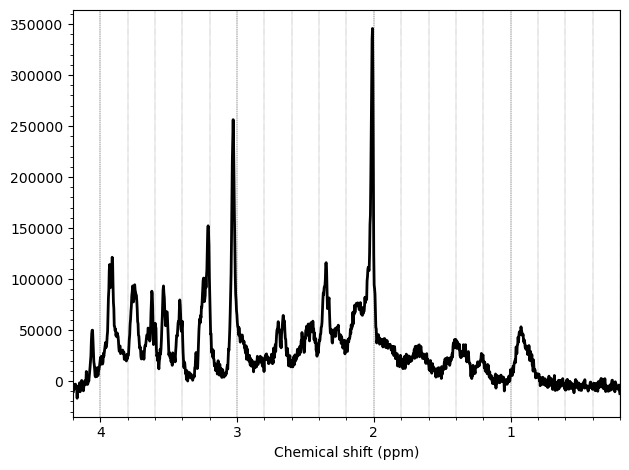

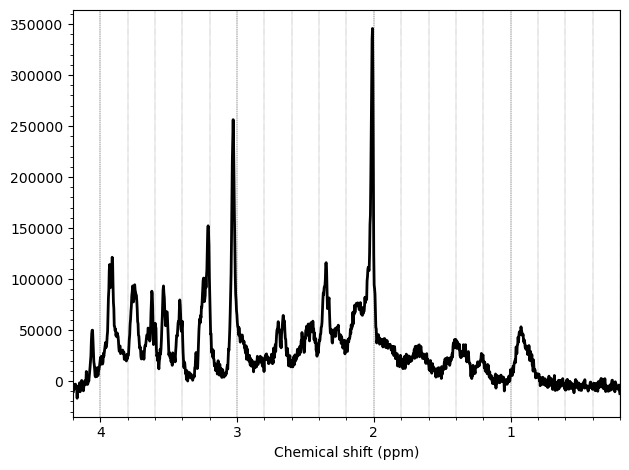

In [11]:
niftis[0].plot()

In [91]:
nifti_dict[bvals[0]]

File sub-01_ses-01_seq_43_dmrs.nii.gz (/data/pt_02093/new_data_structure/CHUV/2025_04_24_dMR_S_I/20250424/derivatives/preprocessed/sub-01/ses-01/dmrs)
NIfTI-MRS version 0.9
Data shape (1, 1, 1, 4096, 1)
Dimension tags: ['DIM_USER_0', None, None]
Spectrometer Frequency: 400.263989952738 MHz
Dwelltime (Spectral bandwidth): 2.000E-04 s (5000 Hz)
Nucleus: 1H
Field Strength: 9.40 T

In [86]:
these_niftis_bvals = sorted(dict(zip(these_niftis,bvals )))


TypeError: '<' not supported between instances of 'NIFTI_MRS' and 'NIFTI_MRS'

In [81]:
these_niftis_sorted

[File sub-01_ses-01_seq_46_dmrs.nii.gz (/data/pt_02093/new_data_structure/CHUV/2025_04_24_dMR_S_I/20250424/derivatives/preprocessed/sub-01/ses-01/dmrs)
 NIfTI-MRS version 0.9
 Data shape (1, 1, 1, 4096, 1)
 Dimension tags: ['DIM_USER_0', None, None]
 Spectrometer Frequency: 400.263989952738 MHz
 Dwelltime (Spectral bandwidth): 2.000E-04 s (5000 Hz)
 Nucleus: 1H
 Field Strength: 9.40 T,
 File sub-01_ses-01_seq_62_dmrs.nii.gz (/data/pt_02093/new_data_structure/CHUV/2025_04_24_dMR_S_I/20250424/derivatives/preprocessed/sub-01/ses-01/dmrs)
 NIfTI-MRS version 0.9
 Data shape (1, 1, 1, 4096, 1)
 Dimension tags: ['DIM_USER_0', None, None]
 Spectrometer Frequency: 400.263989952738 MHz
 Dwelltime (Spectral bandwidth): 2.000E-04 s (5000 Hz)
 Nucleus: 1H
 Field Strength: 9.40 T,
 File sub-01_ses-01_seq_54_dmrs.nii.gz (/data/pt_02093/new_data_structure/CHUV/2025_04_24_dMR_S_I/20250424/derivatives/preprocessed/sub-01/ses-01/dmrs)
 NIfTI-MRS version 0.9
 Data shape (1, 1, 1, 4096, 1)
 Dimension tags:

In [69]:
sorted(these_niftis,key = lambda x: bvals.index(x))

ValueError: File sub-01_ses-01_seq_46_dmrs.nii.gz (/data/pt_02093/new_data_structure/CHUV/2025_04_24_dMR_S_I/20250424/derivatives/preprocessed/sub-01/ses-01/dmrs)
NIfTI-MRS version 0.9
Data shape (1, 1, 1, 4096, 1)
Dimension tags: ['DIM_USER_0', None, None]
Spectrometer Frequency: 400.263989952738 MHz
Dwelltime (Spectral bandwidth): 2.000E-04 s (5000 Hz)
Nucleus: 1H
Field Strength: 9.40 T
 is not in list

In [64]:
testnifti

NIfTI-MRS version 0.9
Data shape (1, 1, 1, 4096, 5)
Dimension tags: ['DIM_USER_0', None, None]
Spectrometer Frequency: 400.263989952738 MHz
Dwelltime (Spectral bandwidth): 2.000E-04 s (5000 Hz)
Nucleus: 1H
Field Strength: 9.40 T

# LATER: USE EPFL COIL COMBINE instead of water reference peak. 

## Get SPECIAL rephasing into nifti read

In [386]:
def _read_header_file_info(file_path, keys_single, keys_array):
    """Read information from the method file

    :param file_path: path to the header file
    :type file_path: str or pathlib.Path
    :param keys_single: List of header keys that are a single value
    :type keys_single: list of str
    :param keys_array: List of header keys that have array values
    :type keys_array: list of str
    :return: Dict containing the information
    :rtype: dict
    """
    re_searches = [re.compile(fr'({x})\=(\d+)') for x in keys_single]
    re_searches2 = [re.compile(fr'({x})\=\((\s?\d+\s?)\)') for x in keys_array]

    with open(file_path) as fp:
        methodlines = fp.readlines()

    method_values = {}
    for line in methodlines:
        for re_ptrn in re_searches:
            match = re.search(re_ptrn, line)
            if match:
                method_values[match[1]] = int(match[2])

    # For array values that occur on the line after
    for idx, line in enumerate(methodlines):
        for re_ptrn in re_searches2:
            match = re.search(re_ptrn, line)
            if match:
                method_values[match[1]] = np.array(
                    methodlines[idx+1].split(' ')).astype('float')

    return method_values


In [124]:
BRUKERparamnames=["PVM_ArrayPhase", 
                  "PVM_EncChanScaling"];

In [125]:
hdr = _read_header_file_info(f'{path_to_data}/{water_reference_seqeunce_number}/method',[],BRUKERparamnames)

In [126]:
rxarrayphases = hdr['PVM_ArrayPhase']
scalingloops = hdr['PVM_EncChanScaling']

In [27]:
nbtsfid = 4096
nloops = 4

raw_data_coil_rep = []
for coil in range(nloops):
    raw_data_coil_rep.append([])
    for avrep in range(8):
        this_raw = raw_data[(avrep*nbtsfid*2*nloops + coil * nbtsfid*2):(avrep*nbtsfid*2*nloops + coil * nbtsfid*2 + 2*nbtsfid)]
        this_raw_cmplx = this_raw[::2] + 1j*this_raw[1::2]
        raw_data_coil_rep[coil].append(this_raw_cmplx)
raw_data_coil_rep = np.array(raw_data_coil_rep)

In [ ]:
fid_comb_re=zeros(study.nav*study.nrep,nbptsfid);
fid_comb_im=zeros(study.nav*study.nrep,nbptsfid);

fid_reorganized_rephased_re=zeros(nloops,study.nav*study.nrep,nbptsfid);
fid_reorganized_rephased_im=zeros(nloops,study.nav*study.nrep,nbptsfid);

for coil=1:nloops
    fid_comb_re=fid_comb_re + ...
                    (squeeze(real(fid_reorganized(coil,:,:))).*cos(rxarrayphases(coil)/180*pi) ... 
                    -squeeze(imag(fid_reorganized(coil,:,:))).*sin(rxarrayphases(coil)/180*pi)).*scalingloops(coil);

    fid_reorganized_rephased_re(coil,:,:)=(squeeze(real(fid_reorganized(coil,:,:))).*cos(rxarrayphases(coil)/180*pi) ... 
                    -squeeze(imag(fid_reorganized(coil,:,:))).*sin(rxarrayphases(coil)/180*pi)).*scalingloops(coil);

    fid_comb_im= fid_comb_im+ ...
                    (squeeze(real(fid_reorganized(coil,:,:))).*sin(rxarrayphases(coil)/180*pi) ... 
                    +squeeze(imag(fid_reorganized(coil,:,:))).*cos(rxarrayphases(coil)/180*pi)).*scalingloops(coil);

    fid_reorganized_rephased_im(coil,:,:)=(squeeze(real(fid_reorganized(coil,:,:))).*sin(rxarrayphases(coil)/180*pi) ... 
                    +squeeze(imag(fid_reorganized(coil,:,:))).*cos(rxarrayphases(coil)/180*pi)).*scalingloops(coil);
end 


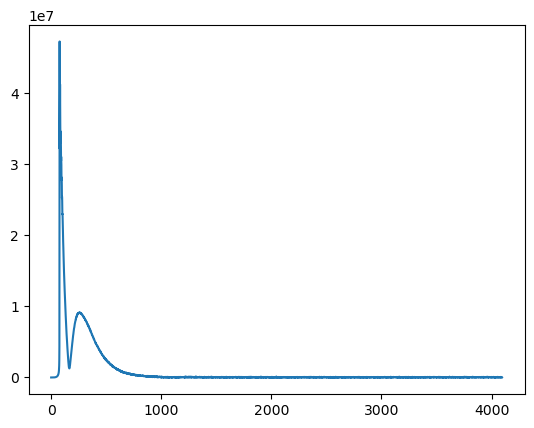

In [39]:
plt.plot(np.absolute(raw_data_coil_rep[0,3,:]))

In [151]:
matdata = loadmat('/data/pt_02093/new_data_structure/CHUV/2025_04_24_dMR_S_I/20250424/Bruker_2025-04-24_41_Toi_check_fidrefscan.mat')

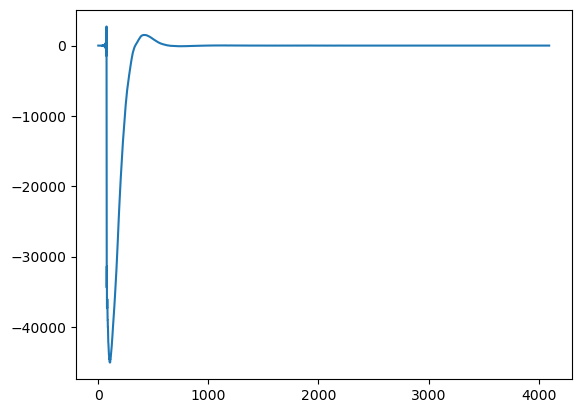

In [152]:
plt.plot(matdata['study'][0]['data'][0]['real'][0][0][0,0])

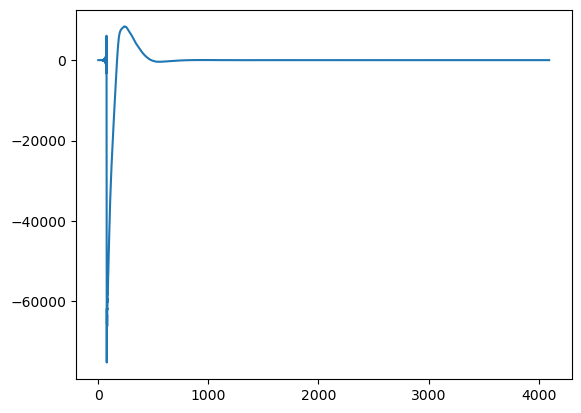

In [153]:
plt.plot(matdata['study'][0]['data'][0]['imag'][0][0][0,0])

In [161]:
matdata['study'][0]['data'][0]['real'][0][0].shape

(1, 1, 4096)

In [162]:
cmplx = matdata['study'][0]['data'][0]['imag'][0][0][:,0]+matdata['study'][0]['data'][0]['real'][0][0][:,0]

In [163]:
absolute = np.absolute(cmplx)

In [243]:
raw_data_cmplx = (raw_data[0::2] + 1j * raw_data[1::2])/2

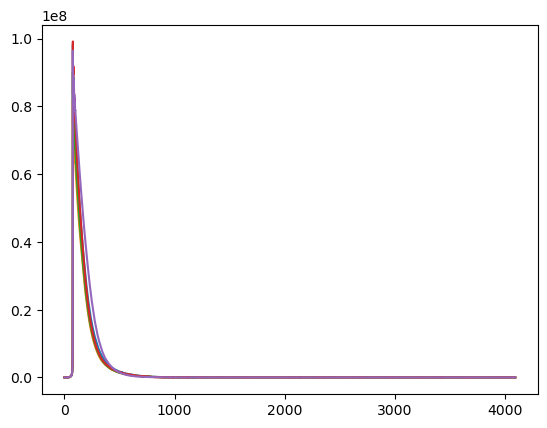

In [250]:
for i in range(8,12):
    plt.plot(np.absolute(raw_data_cmplx[i*4096:(i+1)*4096]))

plt.plot(np.sqrt(matdata['study'][0]['data'][0]['imag'][0][0][0,0]**2+matdata['study'][0]['data'][0]['real'][0][0][0,0]**2)*3000)

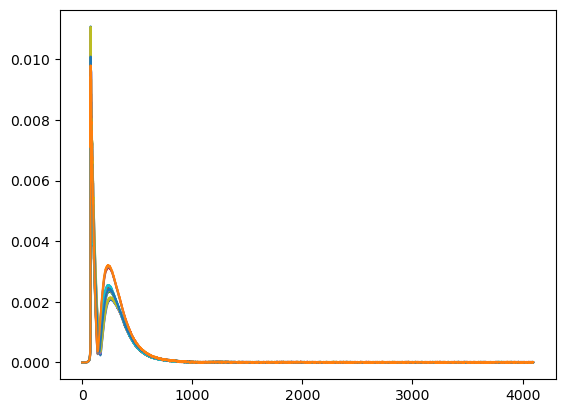

In [208]:
for i in range(4,8):
    plt.plot(np.absolute(raw_data_cmplx[i*4096:(i+1)*4096]))
for i in range(12,16):
    plt.plot(np.absolute(raw_data_cmplx[i*4096:(i+1)*4096]))
for i in range(20,24):
    plt.plot(np.absolute(raw_data_cmplx[i*4096:(i+1)*4096]))


# Old and not working

In [16]:
data_nii_path = f'{path_to_data}/{seqeunce_number}/rawdata_nifti.nii.gz'
water_nii_path = f'{path_to_data}/{water_reference_seqeunce_number}/rawdata_nifti.nii.gz'

In [30]:
data_nii_path

'/data/pt_02093/new_data_structure/CHUV/2025_04_24_dMR_S_I/20250424/51/rawdata_nifti.nii.gz'

In [29]:
!mrs_tools vis $water_nii_path

Performing coil combination
/software/fsl/6.0.7.11/debian-bullseye-amd64/lib/python3.11/site-packages/fsl_mrs/utils/preproc/combine.py:48: UserWarning:

You may not have enough samples to accurately estimate the noise covariance, 10^5 samples recommended.

Averaging DIM_DYN
Figure(640x480)


In [18]:
!fsl_mrs_preproc --output output/ --data $data_nii_path --reference $water_nii_path --report

/software/fsl/6.0.7.11/debian-bullseye-amd64/lib/python3.11/site-packages/fsl_mrs/utils/preproc/combine.py:48: UserWarning:

You may not have enough samples to accurately estimate the noise covariance, 10^5 samples recommended.

Traceback (most recent call last):
  File "/software/fsl/6.0.7.11/debian-bookworm-amd64/bin/fsl_mrs_preproc", line 10, in <module>
    sys.exit(main())
             ^^^^^^
  File "/software/fsl/6.0.7.11/debian-bullseye-amd64/lib/python3.11/site-packages/fsl_mrs/scripts/fsl_mrs_preproc.py", line 240, in main
    supp_data = nifti_mrs_proc.coilcombine(
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/software/fsl/6.0.7.11/debian-bullseye-amd64/lib/python3.11/site-packages/fsl_mrs/utils/preproc/nifti_mrs_proc.py", line 134, in coilcombine
    _, ref_weights[idx_no_t], _ = preproc.combine_FIDs(
       ~~~~~~~~~~~^^^^^^^^^^
ValueError: could not broadcast input array from shape (4,) into shape (4,1)


In [15]:
!echo --output output/ --data $data_nii_path

--output output/ --data /data/pt_02093/new_data_structure/CHUV/2025_04_24_dMR_S_I/20250424/51/rawdata_nifti.nii.gz


In [44]:
import os, subprocess
import brukerapi
from brukerapi.folders import Study
from brukerapi.dataset import Dataset
from matplotlib import pyplot as plt
import spec2nii as s2n
from spec2nii import bruker as b2n
from spec2nii.spec2nii import main, spec2nii

In [24]:
brukerapi

<module 'brukerapi' from '/data/u_mbrammerloh_diss/tools/anaconda3/lib/python3.12/site-packages/brukerapi/__init__.py'>

In [4]:
spec2nii_command = "./spec2nii bruker -m FID "
subprocess.call(spec2nii_command)

FileNotFoundError: [Errno 2] No such file or directory: './spec2nii bruker -m FID '

In [112]:
study = Dataset('/data/pt_02093/new_data_structure/CHUV/2025_04_24_dMR_S_I/20250424/47/fid')

ZeroDivisionError: float division by zero

In [111]:
study = Study('/data/pt_02093/new_data_structure/CHUV/2025_04_24_dMR_S_I/20250424/',)

NotStudyFolder: Not a Bruker study folder.

In [105]:
study.dim_type

['spectroscopic', '<FG_CYCLE>']

[[<matplotlib.lines.Line2D at 0x7f0ebd74ae10>]]

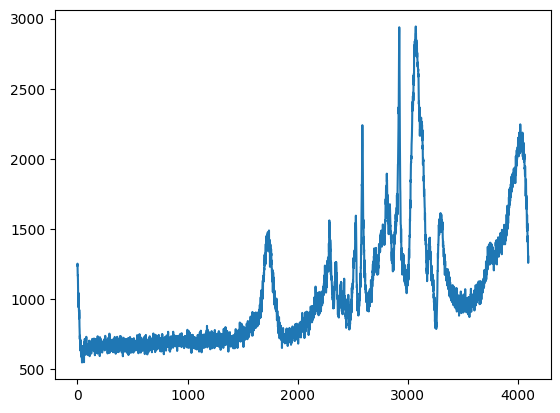

In [104]:
[plt.plot(study.data[:].mean(axis=1))]

In [7]:
data_folder='/data/pt_02093/new_data_structure/CHUV/2025_04_24_dMR_S_I/20250424'
for sequencedir in range(41,63):
    spec2nii_command = "spec2nii bruker -m 2DSEQ " + os.path.join(data_folder,str(sequencedir), 'pdata','1','2dseq')
    print(spec2nii_command)
    subprocess.call(spec2nii_command)
    break


spec2nii bruker -m 2DSEQ /data/pt_02093/new_data_structure/CHUV/2025_04_24_dMR_S_I/20250424/41/pdata/1/2dseq


FileNotFoundError: [Errno 2] No such file or directory: 'spec2nii bruker -m 2DSEQ /data/pt_02093/new_data_structure/CHUV/2025_04_24_dMR_S_I/20250424/41/pdata/1/2dseq'

In [107]:
!spec2nii bruker /data/pt_02093/new_data_structure/CHUV/2025_04_24_dMR_S_I/20250424/41/fid

Traceback (most recent call last):
  File "/data/u_mbrammerloh_diss/tools/anaconda3/bin/spec2nii", line 8, in <module>
    sys.exit(main())
             ^^^^^^
  File "/data/u_mbrammerloh_diss/tools/anaconda3/lib/python3.12/site-packages/spec2nii/spec2nii.py", line 701, in main
    spec2nii(*args)
  File "/data/u_mbrammerloh_diss/tools/anaconda3/lib/python3.12/site-packages/spec2nii/spec2nii.py", line 297, in __init__
    args.func(args)
  File "/data/u_mbrammerloh_diss/tools/anaconda3/lib/python3.12/site-packages/spec2nii/spec2nii.py", line 670, in bruker
    self.imageOut, self.fileoutNames = read_bruker(args)
                                       ^^^^^^^^^^^^^^^^^
  File "/data/u_mbrammerloh_diss/tools/anaconda3/lib/python3.12/site-packages/spec2nii/bruker.py", line 44, in read_bruker
    for data, orientation, dwelltime, meta, name in yield_bruker(args):
  File "/data/u_mbrammerloh_diss/tools/anaconda3/lib/python3.12/site-packages/spec2nii/bruker.py", line 79, in yield_bruker
    

In [ ]:
read_bruker()


In [13]:
spec2nii()

TypeError: 'module' object is not callable

In [60]:
""" spec2nii - tool for conversion of various MRS data formats to NIFTI format.

This module contains the main class to be called as a script (through the main function).

Author: William Clarke <william.clarke@ndcn.ox.ac.uk>
Copyright (C) 2020 University of Oxford
"""

import argparse
import sys
import os.path as op
from pathlib import Path
import json
from nibabel.nifti2 import Nifti2Image
from spec2nii import __version__ as spec2nii_ver
from numpy import isclose
# There are case specific imports below


class Spec2niiError(Exception):
    pass


class spec2nii:
    def __init__(self):
        cite_str = "Clarke WT, Bell TK, Emir UE, Mikkelsen M, Oeltzschner G, Shamaei A, Soher BJ, Wilson M. "\
                   "NIfTI-MRS: A standard data format for magnetic resonance spectroscopy. "\
                   "Magn Reson Med. 2022. doi: 10.1002/mrm.29418."
        parser = argparse.ArgumentParser(
            description='Convert raw spectroscopy data to NIfTI format.',
            epilog=f"If you use spec2nii please cite: {cite_str}")
        parser.add_argument('-v', '--version', action='version', version=spec2nii_ver)

        subparsers = parser.add_subparsers(title='spec2nii subcommands')

        def add_common_parameters(subparser):
            # Add options that are common to all subcommands
            subparser.add_argument('-j', '--json', help='Create json sidecar.', action='store_true')
            subparser.add_argument("-f", "--fileout", type=str,
                                   help="Output file base name (default = input file name)")
            subparser.add_argument("-o", "--outdir", type=Path,
                                   help="Output location (default = .)", default='.')
            subparser.add_argument('--nifti1', action='store_true')
            subparser.add_argument("--override_nucleus", type=str, nargs='+',
                                   help="Override ResonantNucleus field with input(s). E.g. '2H'.")
            subparser.add_argument("--override_frequency", type=float, nargs='+',
                                   help="Override SpectrometerFrequency field with input(s). Input in MHz.")
            subparser.add_argument("--override_dwelltime", type=float,
                                   help="Override dwell time field with input. Input in seconds.")
            subparser.add_argument(
                '--anon',
                action='store_true',
                help="Create file without sensitive metadata. For greater control use spec2nii anon.")
            subparser.add_argument('--verbose', action='store_true')

            return subparser


        # Bruker format
        parser_bruker = subparsers.add_parser('bruker', help='Convert from Bruker data format.')
        parser_bruker.add_argument('file', help='2dseq file to convert', type=str)
        parser_bruker.add_argument('-q', '--query', action='append', default=[])
        parser_bruker.add_argument('-m', '--mode', type=str, default='2DSEQ', choices=['2DSEQ', 'FID'])
        parser_bruker.add_argument('-d', '--dump_headers',
                                   help='Dump bruker header files into json header extension',
                                   action='store_true')
        parser_bruker = add_common_parameters(parser_bruker)
        parser_bruker.set_defaults(func=self.bruker)


        if len(sys.argv) == 1:
            parser.print_usage(sys.stderr)
            sys.exit(1)

        args = parser.parse_args()

        self.fileoutNames = []
        self.imageOut = []
        self.orientationInfoOut = []
        self.dwellTimes = []
        self.metaData = []

        self.outputDir = args.outdir

        args.func(args)

        return args
        if self.imageOut:
            self.implement_overrides(args)

            self.insert_spectralwidth()

            if args.anon:
                from spec2nii.anonymise import anon_nifti_mrs
                for idx, nifti_mrs_img in enumerate(self.imageOut):
                    self.imageOut[idx] = anon_nifti_mrs(nifti_mrs_img, verbose=args.verbose)

            self.validate_output()
            self.write_output(args.json, args.nifti1)
            self.validate_write(args.verbose)
            if args.verbose:
                print(f'Please cite {cite_str}.')
        elif hasattr(args, 'view') and not args.view:
            print('No files to write.')

    def implement_overrides(self, args):
        """Implement any command line overrides for essential parameters."""
        for nifti_mrs_img in self.imageOut:
            if args.override_dwelltime:
                nifti_mrs_img.set_dwell_time(args.override_dwelltime)

            if args.override_nucleus or args.override_frequency:
                from nibabel.nifti1 import Nifti1Extension
                hdr_ext_codes = nifti_mrs_img.header.extensions.get_codes()
                index = hdr_ext_codes.index(44)
                original = json.loads(nifti_mrs_img.header.extensions[index].get_content())

                if args.override_nucleus:
                    original['ResonantNucleus'] = args.override_nucleus
                if args.override_frequency:
                    original['SpectrometerFrequency'] = args.override_frequency
                json_s = json.dumps(original)
                new_ext = Nifti1Extension(44, json_s.encode('UTF-8'))
                nifti_mrs_img.header.extensions.clear()
                nifti_mrs_img.header.extensions.append(new_ext)

    def insert_spectralwidth(self):
        """Ensure that the correct spectral width is inserted into the header extension"""
        for nifti_mrs_img in self.imageOut:
            if 'SpectralWidth' in nifti_mrs_img.hdr_ext\
                    and not isclose(
                        nifti_mrs_img.hdr_ext['SpectralWidth'],
                        1 / nifti_mrs_img.dwelltime,
                        atol=1E-2):
                nifti_mrs_img.remove_hdr_field('SpectralWidth')
                nifti_mrs_img.add_hdr_field('SpectralWidth', 1 / nifti_mrs_img.dwelltime)
            else:
                nifti_mrs_img.add_hdr_field('SpectralWidth', 1 / nifti_mrs_img.dwelltime)

    def validate_output(self):
        """Run NIfTI MRS validation on output."""
        import nifti_mrs.validator as validate
        # Currently this repeats the validation before the save.
        # But useful here to do exception handling
        for f_out, nifti_mrs_img in zip(self.fileoutNames, self.imageOut):
            try:
                validate.validate_nifti_mrs(nifti_mrs_img)
            except (
                    validate.headerExtensionError,
                    validate.niftiDataError,
                    validate.niftiHeaderError) as exc:

                raise Spec2niiError(f'Generated file {f_out} failed validation.') from exc

    def write_output(self, write_json=False, nifti1=False):
        """Write any NIfTI MRS objects stored.
        If write_json is true also write meta-data as sidecar.
        """
        self.outputDir.mkdir(parents=True, exist_ok=True)

        for f_out, nifti_mrs_img in zip(self.fileoutNames, self.imageOut):
            out = self.outputDir / (f_out + '.nii.gz')

            if nifti1:
                # If nifti1 is requested just remake the file.
                # This is more than a bit hacky, but avoids passing the option to every end-point.
                from nifti_mrs.create_nmrs import gen_nifti_mrs_hdr_ext
                gen_nifti_mrs_hdr_ext(
                    nifti_mrs_img[:],
                    nifti_mrs_img.dwelltime,
                    nifti_mrs_img.hdr_ext,
                    nifti_mrs_img.getAffine('voxel', 'world'),
                    nifti_version=1)\
                    .save(out)
            else:
                nifti_mrs_img.save(out)

            if write_json:
                out_json = self.outputDir / (f_out + '.json')
                with open(out_json, 'w') as fp:
                    json.dump(json.loads(nifti_mrs_img.header.extensions[0].get_content()), fp, indent=4)

    class NIfTIMRSWriteError(IOError):
        pass

    def validate_write(self, verbose):
        for f_out in self.fileoutNames:
            out = self.outputDir / (f_out + '.nii.gz')
            if out.exists() and verbose:
                print(f'Output {out.name} written to {out.parent}')
            elif out.exists():
                pass
            else:
                raise self.NIfTIMRSWriteError(f'Output {out.name} in {out.parent} not found!')

 

    # Bruker 2dseq files with FG_COMPLEX
    def bruker(self, args):
        #from spec2nii.bruker import read_bruker

        self.imageOut, self.fileoutNames = read_bruker(args)


def main(*args):
    spec2nii(*args)
    return 0

In [73]:
"""spec2nii module containing functions specific to interpreting Bruker formats
Dependent on the brukerapi package developed by Tomas Psorn.
https://github.com/isi-nmr/brukerapi-python

Author: Tomas Psorn <tomaspsorn@isibrno.cz>
        Will Clarke <william.clarke@ndcn.ox.ac.uk>
Copyright (C) 2021 Institute of Scientific Instruments of the CAS, v. v. i.
"""
import os
import importlib.resources as importlib_resources
import warnings
from datetime import datetime

import numpy as np

from brukerapi.dataset import Dataset
from brukerapi.folders import Folder
from brukerapi.mergers import FrameGroupMerger
from brukerapi.exceptions import FilterEvalFalse

from nifti_mrs.create_nmrs import gen_nifti_mrs_hdr_ext
from nifti_mrs.hdr_ext import Hdr_Ext

from spec2nii.nifti_orientation import NIFTIOrient
from spec2nii import __version__ as spec2nii_ver

# Default dimension assignments.
fid_dimension_defaults = {
    'repetition': "DIM_DYN",
    'channel': "DIM_COIL"}


def read_bruker(args):
    """

    :param args:
    :return list imageOut:
    :return list fileoutNames:
    """
    imageOut = []
    fileoutNames = []

    # for all Bruker datasets compliant all queries
    for data, orientation, dwelltime, meta, name in yield_bruker(args):
        print(orientation, dwelltime, meta, name)
        imageOut.append(
            gen_nifti_mrs_hdr_ext(
                data,
                dwelltime,
                meta,
                orientation.Q44,
                no_conj=True)
        )
        fileoutNames.append(name)

    return imageOut, fileoutNames


def yield_bruker(args):
    """

    If the path specified by args.file is:

    1/ Bruker dataset file (2dseq) - function yields its data and properties of the dataset
    2/ Directory - function yields data and properties and data of all datasets compliant to the queries

    """
    # get a list of queries to filter datasets
    queries = _get_queries(args)

    # get location of the spec2nii Bruker properties configuration file
    ref1 = importlib_resources.files('spec2nii') / 'bruker_properties.json'
    ref2 = importlib_resources.files('spec2nii') / 'bruker_fid_override.json'

    with importlib_resources.as_file(ref1) as bruker_properties_path:
        with importlib_resources.as_file(ref2) as bruker_fid_override_path:

            # case of Bruker dataset
            if os.path.isfile(args.file):
                d = Dataset(
                    args.file,
                    property_files=[bruker_fid_override_path, bruker_properties_path],
                    parameter_files=['method'])
                print(queries)
                try:
                    d.query(queries)
                except FilterEvalFalse:
                    raise ValueError(f'Bruker dataset {d.path} is not suitable for conversion to mrs_nifti')
                yield from _proc_dataset(d, args)

            # case of folder containing Bruker datasets
            elif os.path.isdir(args.file):

                # process individual datasets
                for dataset in Folder(args.file, dataset_state={
                    "parameter_files": ['method'],
                    "property_files": [bruker_properties_path]
                }).get_dataset_list_rec():
                    with dataset as d:
                        try:
                            d.query(queries)
                        except FilterEvalFalse:
                            continue
                        yield from _proc_dataset(d, args)


def _get_queries(args):
    """
    Returns a list of queries for filtering out only spectroscopic 2dseq datasets with a complex frame group

    """
    if args.mode == '2DSEQ':
        queries = ["@type=='2dseq'", "@is_spectroscopy==True", "@is_complex==False"]
    elif args.mode == 'FID':
        queries = ["@type=='fid'", "@is_spectroscopy==True"]
    return queries + args.query


def _proc_dataset(d, args):
    """
    Yield data and properties of a single dataset

    """
    # merge 2dseq complex frame group if present
    if d.is_complex and d.type == '2dseq':
        d = FrameGroupMerger().merge(d, 'FG_COMPLEX')

    # prepare the data array
    if d.is_svs:
        data = _prep_data_svs(d)
    elif d.is_mrsi:
        data = _prep_data_mrsi(d)
    else:
        data = d.data

    # get properties
    properties = d.to_dict()

    # Orientation information
    if d.type == 'fid':
        orientation = NIFTIOrient(_fid_affine_from_params(d))
    else:
        orientation = NIFTIOrient(np.reshape(np.array(properties['affine']), (4, 4)))

    # Meta data
    if d.type == 'fid':
        meta = _fid_meta(d, dump=args.dump_headers)
    else:
        meta = _2dseq_meta(d, dump=args.dump_headers)

    # Dwelltime - to do resolve this factor of 2 issue
    if d.type == 'fid':
        dwelltime = d.dwell_s * 2
    else:
        dwelltime = d.dwell_s * 2

    if args.fileout:
        name = args.fileout + '_' + d.id.rstrip('_')
    else:
        name = d.id.rstrip('_')

    yield data, orientation, dwelltime, meta, name


def _prep_data_svs(d):
    """
    Push the spectral dimension of the data array to the 3rd position for SVS data

    It is possible to use tuple as an axis argument of the expand_dims function since numpy>=1.18.0,
    we decided to use this triple call to avoid limiting numpy versions

    """
    data = d.data
    if d.type == 'fid':
        # Remove points acquired before echo
        data = data[d.points_prior_to_echo:, ...]

        # fid data appears to need to be conjugated for NIFTI-MRS convention
        data = data.conj()

    data = np.expand_dims(data, axis=0)
    data = np.expand_dims(data, axis=0)
    data = np.expand_dims(data, axis=0)
    return data


def _2dseq_meta(d, dump=False):
    """ Extract information from method and acqp file into hdr_ext.

    :param d: Dataset
    :return: NIfTI MRS hdr ext object.
    """

    # Extract required metadata and create hdr_ext object
    cf = d.SpectrometerFrequency
    obj = Hdr_Ext(
        cf,
        d.ResonantNucleus)

    # # 5.1 MRS specific Tags
    # 'EchoTime'
    if hasattr(d, 'TE'):
        obj.set_standard_def('EchoTime', float(d.TE * 1E-3))
    elif hasattr(d, 'method_TE'):
        obj.set_standard_def('EchoTime', float(d.method_TE * 1E-3))
    # 'RepetitionTime'
    if hasattr(d, 'TR'):
        obj.set_standard_def('RepetitionTime', float(d.TR / 1E3))
    elif hasattr(d, 'method_TR'):
        obj.set_standard_def('RepetitionTime', float(d.method_TR / 1E3))
    # 'InversionTime'
    # 'MixingTime'
    # 'ExcitationFlipAngle'
    # 'TxOffset'
    # Bit of a guess, not sure of units.
    obj.set_standard_def('TxOffset', float(d.working_offset[0]))
    # 'VOI'
    # 'WaterSuppressed'
    # No apparent parameter stored in the SPAR info.
    # 'WaterSuppressionType'
    # 'SequenceTriggered'
    # # 5.2 Scanner information
    # 'Manufacturer'
    obj.set_standard_def('Manufacturer', 'Bruker')
    # 'ManufacturersModelName'
    # 'DeviceSerialNumber'
    # 'SoftwareVersions'
    obj.set_standard_def('SoftwareVersions', d.PV_version)
    # 'InstitutionName'
    # 'InstitutionAddress'
    # 'TxCoil'
    # 'RxCoil'
    # # 5.3 Sequence information
    # 'SequenceName'
    obj.set_standard_def('SequenceName', d.method_desc)
    # 'ProtocolName'
    # # 5.4 Sequence information
    # 'PatientPosition'
    # 'PatientName'
    obj.set_standard_def('PatientName', d.subj_id)
    # 'PatientID'
    # 'PatientWeight'
    # 'PatientDoB'
    # 'PatientSex'
    # # 5.5 Provenance and conversion metadata
    # 'ConversionMethod'
    obj.set_standard_def('ConversionMethod', f'spec2nii v{spec2nii_ver}')
    # 'ConversionTime'
    conversion_time = datetime.now().isoformat(sep='T', timespec='milliseconds')
    obj.set_standard_def('ConversionTime', conversion_time)
    # 'OriginalFile'
    obj.set_standard_def('OriginalFile', [str(d.path), ])
    # # 5.6 Spatial information
    # 'kSpace'
    obj.set_standard_def('kSpace', [False, False, False])

    # Stuff full headers into user fields
    if dump:
        for hdr_file in d.parameters:
            obj.set_user_def(key=hdr_file,
                             doc=f'Bruker {hdr_file} file.',
                             value=d.parameters[hdr_file].to_dict())

    # Tags
    unknown_count = 0
    for ddx, dim in enumerate(d.dim_type[1:]):
        if dim in fid_dimension_defaults:
            obj.set_dim_info(ddx, fid_dimension_defaults[dim])
        else:
            obj.set_dim_info(ddx, f'DIM_USER_{unknown_count}')
            unknown_count += 1

    return obj


In [74]:
spectrum = spec2nii()

["@type=='2dseq'", '@is_spectroscopy==True', '@is_complex==False']
<spec2nii.nifti_orientation.NIFTIOrient object at 0x7f0ebe885970> 6.25e-07 {"SpectrometerFrequency": [400.263989952738], "ResonantNucleus": ["1H"], "dim_5": "DIM_DYN", "EchoTime": 0.0, "RepetitionTime": 3.0, "TxOffset": 0.0, "Manufacturer": "Bruker", "SoftwareVersions": "<PV-360.3.5>", "SequenceName": "<specialDW_water_b50_avg8>", "PatientName": "Rat^^^^", "ConversionMethod": "spec2nii v0.8.6", "ConversionTime": "2025-04-30T11:20:57.988", "OriginalFile": ["/data/pt_02093/new_data_structure/CHUV/2025_04_24_dMR_S_I/20250424/41/pdata/1/2dseq"], "kSpace": [false, false, false]} 2DSEQ_41_1_Rat^^^^_11


ValueError: data must be complex

In [32]:
import re
sysargv = ['spec2nii','bruker', '-m', '2DSEQ', '/data/pt_02093/new_data_structure/CHUV/2025_04_24_dMR_S_I/20250424/41/pdata/1/2dseq']
sysargv[0] = re.sub(r'(-script\.pyw?|\.exe)?$', '', sysargv[0])

In [33]:
sysargv

['spec2nii',
 'bruker',
 '-m',
 '2DSEQ',
 '/data/pt_02093/new_data_structure/CHUV/2025_04_24_dMR_S_I/20250424/41/pdata/1/2dseq']

In [35]:
data

<generator object yield_bruker at 0x7f0ebd4cd5a0>

In [36]:
spec2nii.auto(sysargv)

NameError: name 'spec2nii' is not defined

In [37]:
spec2nii_class.spec2nii.auto()

NameError: name 'spec2nii_class' is not defined

In [38]:
import sys

In [39]:
sys.argv = sysargv

In [40]:
sys.argv

['spec2nii',
 'bruker',
 '-m',
 '2DSEQ',
 '/data/pt_02093/new_data_structure/CHUV/2025_04_24_dMR_S_I/20250424/41/pdata/1/2dseq']

In [42]:
spec2nii_data = spec2nii()

NameError: name 'spec2nii' is not defined

In [ ]:
data = s2n.bruker.yield_bruker(sysargv)

In [ ]:
for data, orientation, dwelltime, meta, name in yield_bruker(args):
        imageOut.append(
            gen_nifti_mrs_hdr_ext(
                data,
                dwelltime,
                meta,
                orientation.Q44,
                no_conj=True)
        )
        fileoutNames.append(name)